<a href="https://colab.research.google.com/github/cagBRT/Diffusers/blob/main/Latent_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative image models learn a "latent manifold" of the visual world: a low-dimensional vector space where each point maps to an image. Going from such a point on the manifold back to a displayable image is called "decoding" -- in the Stable Diffusion model, this is handled by the "decoder" model.

# Install the necessary libraries

In [1]:
!pip install keras-cv tensorflow --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.2/756.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 33.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    F

In [2]:
!pip install keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 8.5 MB/s eta 0:00:00


In [3]:
import keras_core as keras

Using TensorFlow backend


In [4]:
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from PIL import Image

# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Select the stable diffusion model

In [5]:
# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


# Write two prompts<br>
# Select the number of steps for the latent space

In [6]:
prompt_1 = "A watercolor painting of a ballerina dancing at the beach"
#prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
interpolation_steps = 5

# squeeze=Removes dimensions of size 1 from the shape of a tensor.
encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))

#Generates evenly-spaced values in an interval along a given axis.
interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)

# Show the size of the latent manifold
print(f"Encoding shape: {encoding_1.shape}")

492466864/492466864 [==============================] - 5s 0us/step
Encoding shape: (77, 768)


# Generate images

In [7]:
#seed = 12345
noise = tf.random.normal((512 // 8, 512 // 8, 4))#, seed=seed)

images = model.generate_image(
    interpolated_encodings,
    batch_size=interpolation_steps,
    diffusion_noise=noise,
)

198180272/198180272 [==============================] - 2s 0us/step


In [8]:
images[2]

array([[[140, 142, 148],
        [144, 145, 153],
        [140, 143, 153],
        ...,
        [118,  42,  44],
        [121,  47,  49],
        [119,  59,  57]],

       [[143, 144, 155],
        [140, 142, 154],
        [139, 142, 154],
        ...,
        [131,  45,  46],
        [137,  50,  49],
        [130,  51,  47]],

       [[142, 144, 156],
        [142, 144, 156],
        [140, 144, 155],
        ...,
        [137,  52,  51],
        [137,  50,  49],
        [130,  47,  43]],

       ...,

       [[166, 160, 158],
        [163, 156, 154],
        [166, 160, 159],
        ...,
        [159, 148, 143],
        [156, 143, 140],
        [156, 146, 140]],

       [[166, 162, 159],
        [166, 160, 156],
        [165, 159, 156],
        ...,
        [157, 145, 141],
        [159, 150, 142],
        [156, 147, 141]],

       [[167, 161, 159],
        [166, 163, 160],
        [167, 161, 158],
        ...,
        [160, 152, 147],
        [159, 152, 144],
        [163, 155, 147]]

# Create a GIF from the images

In [9]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

export_as_gif(
    "doggo-and-fruit-5.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=2,
    rubber_band=True,
)

In [10]:
images[4]

array([[[[136, 153, 166],
         [136, 151, 170],
         [132, 151, 171],
         ...,
         [103, 123, 159],
         [102, 123, 159],
         [109, 127, 157]],

        [[136, 152, 171],
         [134, 151, 172],
         [132, 151, 172],
         ...,
         [101, 120, 158],
         [105, 125, 162],
         [103, 122, 159]],

        [[134, 151, 172],
         [134, 152, 174],
         [133, 152, 173],
         ...,
         [104, 122, 161],
         [110, 129, 167],
         [105, 125, 162]],

        ...,

        [[170, 162, 146],
         [168, 160, 144],
         [169, 160, 143],
         ...,
         [153, 124,  85],
         [152, 121,  85],
         [154, 126,  87]],

        [[171, 164, 149],
         [171, 162, 146],
         [170, 160, 144],
         ...,
         [156, 125,  87],
         [155, 126,  85],
         [154, 125,  85]],

        [[169, 163, 150],
         [172, 166, 149],
         [171, 163, 147],
         ...,
         [156, 127,  89],
        

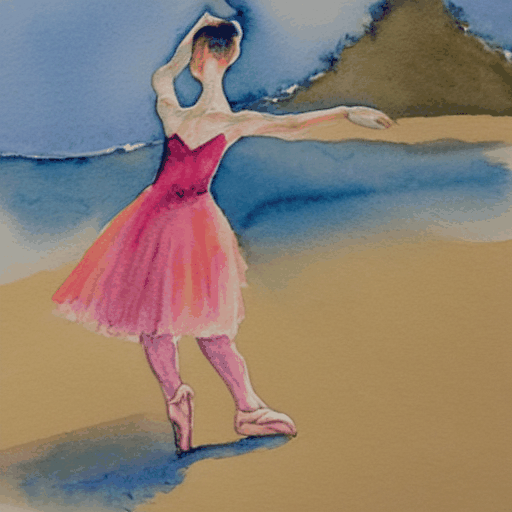

In [11]:
from IPython.display import Image as IImage
IImage("doggo-and-fruit-5.gif")

Perhaps unsurprisingly, walking too far from the encoder's latent manifold produces images that look incoherent. Try it for yourself by setting your own prompt, and adjusting step_size to increase or decrease the magnitude of the walk. <br><br>
Note that when the magnitude of the walk gets large, the walk often leads into areas which produce extremely noisy images.

In [ ]:
walk_steps = 100
batch_size = 3
batches = walk_steps // batch_size
step_size = 0.005

encoding = tf.squeeze(
    model.encode_text("The Eiffel Tower in the style of starry night")
)
# Note that (77, 768) is the shape of the text encoding.
delta = tf.ones_like(encoding) * step_size

walked_encodings = []
for step_index in range(walk_steps):
    walked_encodings.append(encoding)
    encoding += delta
walked_encodings = tf.stack(walked_encodings)
batched_encodings = tf.split(walked_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("eiffel-tower-starry-night.gif", images, rubber_band=True)

In [ ]:
images[0]

In [ ]:
images[230]

In [ ]:
len(images)

In [ ]:
from IPython.display import Image as IImage
IImage("eiffel-tower-starry-night.gif")